# Evaluating the value of battery storage to balance rooftop PV in Belgium: An open-sourced calculation

The recent dislosure of the Tesla Powerwall home battery has entailed high expectations in the energy field. Many observers predict an uptake of such PV/Battery units, which could ultimately disconnect from the grid and lead to totally autonomous home or minigrid systems. The goal of this notebook is to evaluate the profitability and potential of the 7 kWh Tesla battery in the Belgian system under different hypotheses. 

For the sake of openness, the selected format is the open-source Ipython Notebook format, which allows to easily follow and check all calculations and hypotheses. The input data is public data and is also made available through csv files. The original ipynb file can be downloaded here and allows further reuse/modification/adaptation of the notebook: http://squoilin.github.io/home_batteries/Home_Batteries.ipynb

Sylvain Quoilin 

Researcher at the European Commission (JRC).

E-mail: sylvain.quoilin@ec.europa.eu - Twitter: @squoilin

NB: The views expressed are purely those of the author and may not in any circumstances be regarded as stating an official position of the European Commission.

July 2015

## Loading Libraries and input data

All libraries are standard libraries that can be downloaded using pip or a package manager.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import urllib
%matplotlib inline

Download data:

In [2]:
urllib.urlretrieve ("http://squoilin.github.io/home_batteries/solar_data.csv", "solar_data.csv")
urllib.urlretrieve ("http://squoilin.github.io/home_batteries/demand.csv", "demand.csv")

('demand.csv', <httplib.HTTPMessage instance at 0x7fcfd020f7a0>)

The PV production data is the 2014 data published by Elia, the Belgian TSO. This data is aggregated for the whole Belgium area, and is therefore smoothed out. This is deemed acceptable since the main focus is the day-night storage capability of the system and not the fast minute-by-minute variations. 
The value of interest is the 15-min availability factor of solar PV. It is obtained by dividing the measured production by the installed capacity:

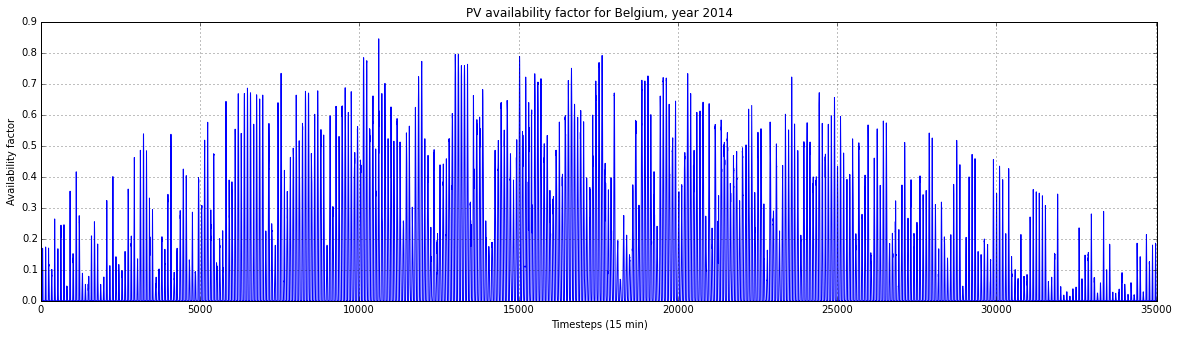

In [3]:
solar_data = pd.read_csv('solar_data.csv')
AvailabilityFactor_PV = solar_data['Corrected Upscaled Measurement [MW]']/solar_data['Monitored Capacity [MWp]']
plt.figure(figsize=(20,5))
AvailabilityFactor_PV.plot()
plt.ylabel('Availability factor')
plt.xlabel('Timesteps (15 min)')
plt.title('PV availability factor for Belgium, year 2014')

The load profile data for an average household is obtained from http://hdl.handle.net/2268/147390. The
data timestep is 15 min, the units are kWh. 

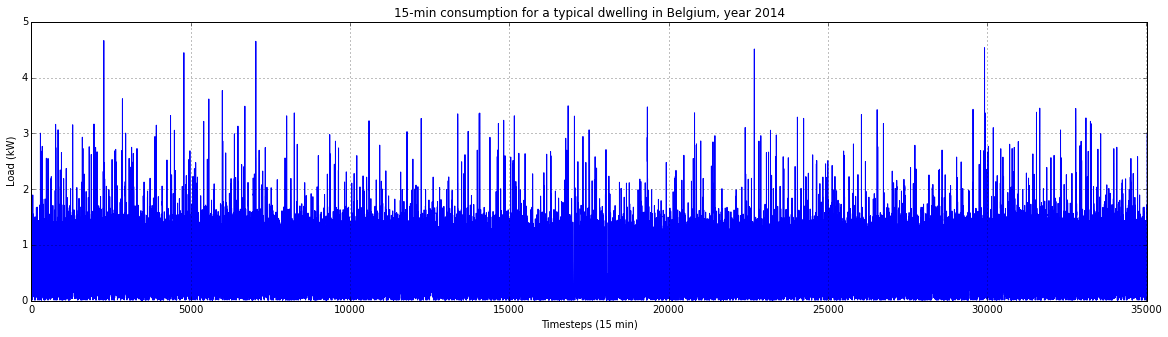

In [4]:
load_data = pd.read_csv('demand.csv')/1000
load = load_data['All 4000']
TotalLoad = load.sum()/4
plt.figure(figsize=(20,5))
load.plot()
plt.ylabel('Load (kW)')
plt.xlabel('Timesteps (15 min)')
plt.title('15-min consumption for a typical dwelling in Belgium, year 2014')

Plotting a typical summerweek with 5 kW PV and 4000 kWh household:

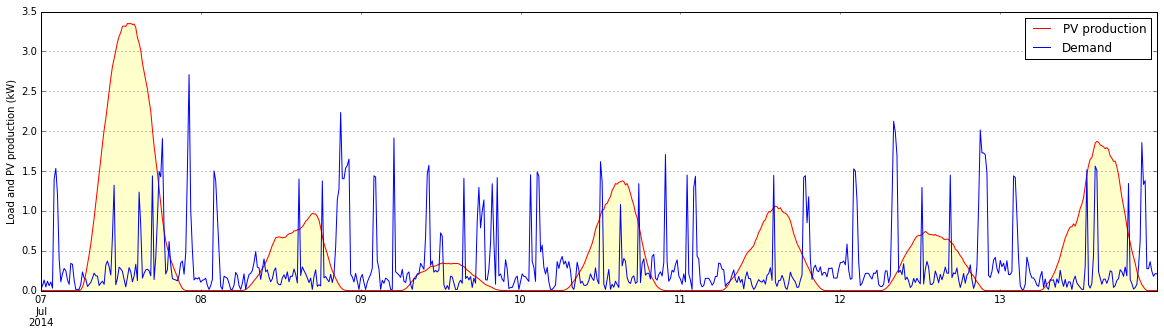

In [5]:
%matplotlib inline

PV_week = AvailabilityFactor_PV[17948:18619]*5
Demand_week = load[17948:18619]
Demand_week.name = 'Demand'
PV_week.name = 'PV production'
dates = pd.date_range(start='2014.07.07',periods=len(Demand_week),freq='15min')
Demand_week.index = dates
PV_week.index = dates

plt.figure(figsize=(20,5))
PV_week.plot(legend=True,color='red')
Demand_week.plot(legend=True,color='blue')
plt.ylabel('Load and PV production (kW)')

plt.fill_between(dates.values,PV_week.values,0,color='yellow',alpha='0.2')


## Hypotheses

The battery characteristics correspond to the Tesla 7 kWh battery. According to Tesla, it is the only one designed for daily cycles (the 10 kWh model is designed for weekly cycles)

In [6]:
BatteryCapacity = 7 # kWh
BatteryCost = 3000*0.9   # Euros
InstallationCost = 500
StorageCost_kWh = BatteryCost/BatteryCapacity
BatteryEfficiency = 0.92   
BatteryLifetime = 10    # years
InterestRate = 0.03   # The interest rate must be a real interest rat (i.e. interest rate - inflation)

The PV home system is assumed to be a 5 kW system, corresponding to a yearly production equal to the demand (5000 kWh). 

Levelized cost of rooftop PV in Belgium is assumed to be 110EUR/MWh. This value is close to the feed-in-tariff proposed in Germany, which is assumed to reflect well the cost of producing electricity.

In [7]:
PVPower = 5   # kW
LCOE_PV = 0.110   # EUR/kWh
InverterEfficiency = 0.96

## Yearly simulation

The dispatch of the storage capacity is performed to maximize self-consumption: battery is charging when PV power is higher than the load and as long as it is not fully charged. It is discharging as soon as PV power is lower than the load and as long as it is not fully discharged.
It is assumed that demand is not responsive.

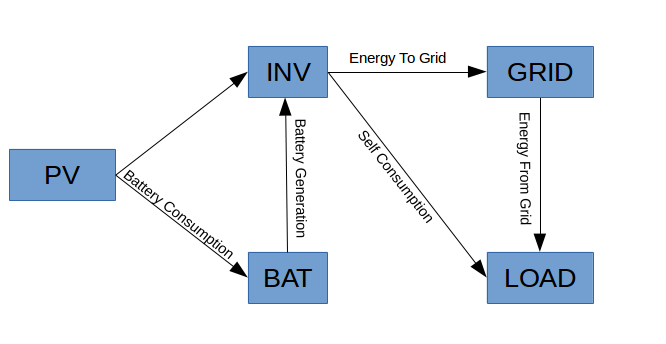

In [16]:
urllib.urlretrieve ("http://squoilin.github.io/home_batteries/system.png", "system.png")
from IPython.display import Image
Image(filename='system.png')

In [9]:
# Yearly simulation is put in a function so that we can call it back later:
def yearly_simulation(PV,load,BatteryCapacity,timestep):
    #Initialize variables:
    Nsteps = len(PV)
    LevelOfCharge = np.zeros(Nsteps)        # kWh
    EnergyFromGrid = np.zeros(Nsteps)       # kWh
    EnergyToGrid = np.zeros(Nsteps)         # kWh
    BatteryGeneration = np.zeros(Nsteps)    # kW
    BatteryConsumption = np.zeros(Nsteps)   # kW
    
    LevelOfCharge[0] = BatteryCapacity/2
    
    for i in range(1,Nsteps):
        LevelOfCharge[i] = LevelOfCharge[i-1] + (np.maximum(0,PV[i] - load[i]/InverterEfficiency) - np.maximum(0,load[i]/InverterEfficiency - PV[i])/BatteryEfficiency)*timestep
        if LevelOfCharge[i] < 0:
            EnergyFromGrid[i] = -LevelOfCharge[i] * BatteryEfficiency * InverterEfficiency
            LevelOfCharge[i] = 0
        elif LevelOfCharge[i] > BatteryCapacity:
            EnergyToGrid[i] = LevelOfCharge[i] - BatteryCapacity
            LevelOfCharge[i] = BatteryCapacity
            
        BatteryGeneration[i] = np.maximum(0,LevelOfCharge[i-1] - LevelOfCharge[i]) * BatteryEfficiency / timestep
    
    BatteryConsumption = np.maximum(0,LevelOfCharge - np.roll(LevelOfCharge,1))/timestep
    return [BatteryGeneration,BatteryConsumption,LevelOfCharge,EnergyFromGrid,EnergyToGrid]

PV = AvailabilityFactor_PV * PVPower
timestep = 0.25
[BatteryGeneration,BatteryConsumption,LevelOfCharge,EnergyFromGrid,EnergyToGrid] = yearly_simulation(PV,load,BatteryCapacity,timestep)




Plotting the state of charge of the battery:

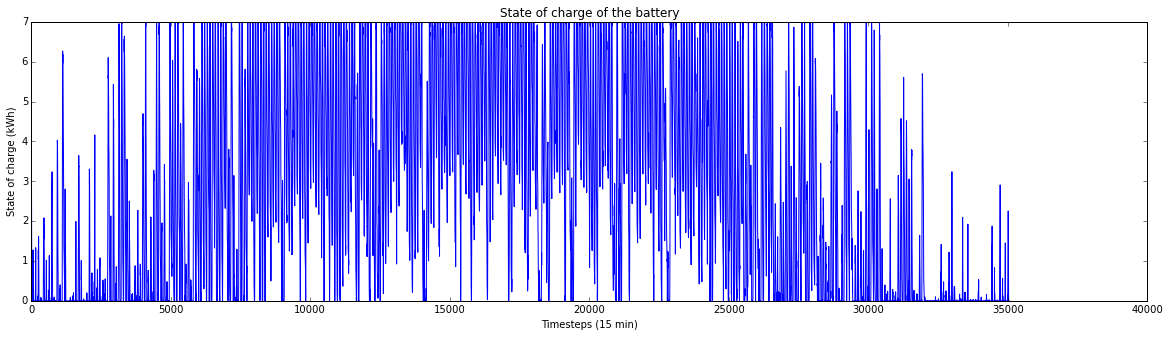

In [10]:
%matplotlib inline
plt.figure(figsize=(20,5))
plt.plot(LevelOfCharge)
plt.ylabel('State of charge (kWh)')
plt.xlabel('Timesteps (15 min)')
plt.title('State of charge of the battery')
plt.show()

Computing the yearly balances:

In [11]:
TotalFromGrid = np.sum(EnergyFromGrid)
TotalToGrid = np.sum(EnergyToGrid)
TotalPV = PV.sum()/4
TotalBatteryGeneration = np.sum(BatteryGeneration/4)
TotalBatteryConsumption = np.sum(BatteryConsumption/4)
BatteryLosses = (np.sum(BatteryConsumption) - np.sum(BatteryGeneration))/4
InverterLosses = (TotalPV - BatteryLosses)*(1-InverterEfficiency)
SelfConsumptionRate = (TotalLoad - TotalFromGrid)/TotalPV*100             # in % 
SelfSufficencyRate = (TotalLoad - TotalFromGrid)/TotalLoad * 100          # in % 
SSR = SelfSufficencyRate
AverageDepth = np.sum(BatteryGeneration/4)/(365 * BatteryCapacity)
Nfullcycles = 365*AverageDepth

print 'Total yearly consumption: ' + str(TotalLoad) + ' kWh'
print 'Total PV production: ' + str(TotalPV) + ' kWh'
print 'Self Consumption: ' + str(TotalLoad - TotalFromGrid) + ' kWh'
print 'Self consumption rate (SCR): '  + str(SelfConsumptionRate) + '%'
print 'Self sufficiency rate (SSR): ' + str(SelfSufficencyRate) + '%'
print 'Amount of energy provided by the battery: ' + str(TotalBatteryGeneration) + ' kWh'
print 'Average Charging/Discharging depth: ' + str(AverageDepth)
print 'Number of equivalent full cycles per year: ' + str(Nfullcycles)
print 'Total battery losses: ' + str(BatteryLosses) + ' kWh'
print 'Total inverter losses: ' + str(InverterLosses) + ' kWh'

# Check residue:
#residue = TotalPV + TotalFromGrid - TotalToGrid - BatteryLosses - InverterLosses - TotalLoad
#residue = (TotalPV - BatteryLosses)*InverterEfficiency - (TotalLoad + TotalToGrid - TotalFromGrid)
#residue

Total yearly consumption: 4016.29279031 kWh
Total PV production: 5068.54186131 kWh
Self Consumption: 2807.38960783 kWh
Self consumption rate (SCR): 55.3885058987%
Self sufficiency rate (SSR): 69.900023589%
Amount of energy provided by the battery: 1531.39708414 kWh
Average Charging/Discharging depth: 0.599372635673
Number of equivalent full cycles per year: 218.771012021
Total battery losses: 133.164963839 kWh
Total inverter losses: 197.415075899 kWh


## Economics

The average cost of one kWh provided by the battery is obtained by computing the total battery-generated energy over its lifetime, divided by the investment cost.

In [12]:
YearlyPayment = -np.pmt(InterestRate, BatteryLifetime, BatteryCost+InstallationCost)
LCOE_battery = YearlyPayment / TotalBatteryGeneration
print 'The ' + str(BatteryLifetime) + '-years levelized cost of one stored kWh is ' + str(LCOE_battery*1000) + ' EUR/MWh'

The 10-years levelized cost of one stored kWh is 244.964304177 EUR/MWh


## Parametric study

In [13]:
# Number of runs:
N = 50

# Dependent variables:
PVPower_vec = np.ones(N) * PVPower
BatteryCapacity_vec = np.ones(N) * BatteryCapacity

# Output variables
TotalFromGrid = np.zeros(N)
TotalToGrid = np.zeros(N)
TotalPV = np.zeros(N)
TotalBatteryGeneration = np.zeros(N)
TotalBatteryConsumption = np.zeros(N)
BatteryLosses = np.zeros(N)
InverterLosses = np.zeros(N)
SelfConsumptionRate = np.zeros(N)
SelfSufficencyRate = np.zeros(N)
AverageDepth = np.zeros(N)
Nfullcycles = np.zeros(N)
LCOE_battery = np.zeros(N)

CapacityMax = 20

for i in range(N):
    BatteryCapacity_vec[i] = 0.01 + float(i)/(N-1) * CapacityMax
    #PVPower_vec[i] = 4 + float(i)/(N-1) * 17
    PV = AvailabilityFactor_PV * PVPower_vec[i]
    [BatteryGeneration,BatteryConsumption,LevelOfCharge,EnergyFromGrid,EnergyToGrid] = yearly_simulation(PV,load,BatteryCapacity_vec[i],timestep)
    TotalFromGrid[i] = np.sum(EnergyFromGrid)
    TotalToGrid[i] = np.sum(EnergyToGrid)
    TotalPV[i] = PV.sum()/4
    TotalBatteryGeneration[i] = np.sum(BatteryGeneration/4)
    TotalBatteryConsumption[i] = np.sum(BatteryConsumption/4)
    BatteryLosses[i] = (np.sum(BatteryConsumption) - np.sum(BatteryGeneration))/4
    InverterLosses[i] = (TotalPV[i] - BatteryLosses[i])*(1-InverterEfficiency)
    SelfConsumptionRate[i] = (TotalLoad - TotalFromGrid[i])/TotalPV[i]*100             # in % 
    SelfSufficencyRate[i] = (TotalLoad - TotalFromGrid[i])/TotalLoad * 100          # in % 
    AverageDepth[i] = np.sum(BatteryGeneration)/4/(365 * BatteryCapacity_vec[i])
    Nfullcycles[i] = 365*AverageDepth[i]
    YearlyPayment = -np.pmt(InterestRate, BatteryLifetime, StorageCost_kWh*BatteryCapacity_vec[i]+InstallationCost)
    LCOE_battery[i] = YearlyPayment / TotalBatteryGeneration[i]


### Plotting:

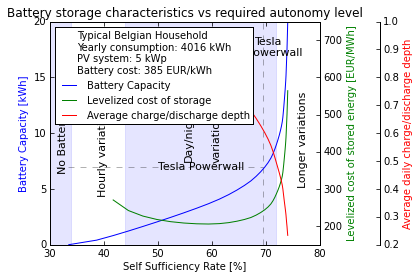

In [14]:
from mpl_toolkits.axes_grid1 import host_subplot
import mpl_toolkits.axisartist as AA
%matplotlib inline
host = host_subplot(111, axes_class=AA.Axes)
plt.subplots_adjust(right=0.75)
par1 = host.twinx()
par2 = host.twinx()
offset = 60
new_fixed_axis = par2.get_grid_helper().new_fixed_axis
par2.axis["right"] = new_fixed_axis(loc="right",
                                    axes=par2,
                                    offset=(offset, 0))
par2.axis["right"].toggle(all=True)
host.set_xlim(30, 80)
host.set_ylim(0, CapacityMax)
host.set_xlabel("Self Sufficiency Rate [%]",fontsize=28)
host.set_ylabel("Battery Capacity [kWh]",fontsize=18)
par1.set_ylabel("Levelized cost of stored energy [EUR/MWh]",fontsize=18)
par2.set_ylabel("Average daily charge/discharge depth",fontsize=18)
p1, = host.plot(SelfSufficencyRate,BatteryCapacity_vec, label="Battery Capacity")
p2, = par1.plot(SelfSufficencyRate[2:],LCOE_battery[2:]*1000, label="Levelized cost of storage")
p3, = par2.plot(SelfSufficencyRate,np.minimum(0.97,AverageDepth), label="Average charge/discharge depth")
par1.set_ylim(150, 750)
#par2.set_ylim(1, 65)
host.legend(title='Typical Belgian Household \nYearly consumption: ' + str(int(TotalLoad)) + ' kWh\nPV system: ' + str(PVPower) + ' kWp \nBattery cost: ' + str(int(StorageCost_kWh)) + ' EUR/kWh' ,loc='upper left',fontsize=10)
host.axis["left"].label.set_color(p1.get_color())
par1.axis["right"].label.set_color(p2.get_color())
par2.axis["right"].label.set_color(p3.get_color())
host.fill_between((30,34),0,2200,alpha=0.1,color='b')
host.fill_between((44,72),0,2200,alpha=0.1,color='b')
host.text(31.5,11,'No Battery', rotation=90,fontsize=11)
host.text(39,12,'Hourly variations', rotation=90,fontsize=11)
host.text(55,11.5,'Day/night', rotation=90,fontsize=11)
host.text(60,11.5,'variations', rotation=90,fontsize=11)
host.text(76,13,'Longer variations', rotation=90,fontsize=11)
host.vlines(69.5,0,1000,linestyle='dashed',alpha=0.3)
host.hlines(7,0,69.5,linestyle='dashed',alpha=0.3)
host.text(68,18,'Tesla',fontsize=11)
host.text(67,17,'Powerwall',fontsize=11)
host.text(50,6.8,'Tesla Powerwall', fontsize=11)
plt.title('Battery storage characteristics vs required autonomy level')